In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
def GetDatosEncuesta():
    """Obtener el dataset.

    Devuelve
    --------
        pd.DataFrame: El dataset con los datos de la encuesta descargado desde el drive.
    """
    return pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')

def GetEncuesta():
    """Obtener el dataset.

    Devuelve
    --------
        pd.DataFrame: El dataset con los resultados de la encuesta descargado desde el drive.
    """
    return pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')



# Preguntas inciales
- ¿Los datos están completos? ¿son consistentes?
- ¿Las columnas aportan información relevante?
- ¿Los datos sirven para generar una conclusión?
- ¿Los datos se encuentra balanceados?
- ¿Se pueden eliminar entradas con poca importancia (outliers)?
- ¿Podemos agrupar datos?
- ¿Podemos imputar datos faltantes?


Para responder estas preguntas realizamos el siguiente análisis

# Inspección inicial de datos de la encuesta
Importamos los datos en un dataframe y hacemos un análisis de la estructura del mismo.

In [3]:
# Importamos csv con los datos
df_datos_encuesta = GetDatosEncuesta()

In [4]:
# Inspeccionamos las columnas que forman los datos
df_datos_encuesta.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [5]:
# Inspeccionamos las dimensiones iniciales del dataframe
df_datos_encuesta.shape

(801, 11)

In [6]:
# Analizamos la integridad de las columnas amigos y parientes 
# Verificamos que no tengan valores nulos y que solo tengan valores numericos enteros positivos

In [7]:
df_datos_encuesta['amigos'].isnull().sum()

0

In [8]:
df_datos_encuesta['parientes'].isnull().sum()

0

In [9]:
df_datos_encuesta['amigos'].value_counts()

0    557
1    179
2     25
4     15
3     14
8      6
5      5
Name: amigos, dtype: int64

In [10]:
df_datos_encuesta['parientes'].value_counts()

0    607
1    110
2     70
3      5
5      4
4      4
6      1
Name: parientes, dtype: int64

In [11]:
# Analizamos la columna 'tipo_de_sala'
# Verificamos que no tenga valores nulos
df_datos_encuesta['tipo_de_sala'].isnull().sum()

0

In [12]:
df_datos_encuesta['tipo_de_sala'].value_counts()

4d        447
normal    187
3d        167
Name: tipo_de_sala, dtype: int64

In [13]:
# Analizamos la columna 'id_usuario' es busca de usuarios repetidos
df_datos_encuesta['id_usuario'].duplicated(keep=False).value_counts()

False    801
Name: id_usuario, dtype: int64

In [14]:
# Verifico que no tenga valores nulos
df_datos_encuesta['id_usuario'].isnull().sum()

0

In [15]:
# Analizamos la columna 'nombre_sede', verificamos que no tenga valores nulos
df_datos_encuesta['nombre_sede'].isnull().sum()

2

In [16]:
# Verifico que la columna genero no tenga nulos y solo tenga valores mujer/hombre
df_datos_encuesta['genero'].isnull().sum()

0

In [17]:
df_datos_encuesta['genero'].value_counts()

hombre    513
mujer     288
Name: genero, dtype: int64

In [18]:
# Analizamos la columna 'fila'
df_datos_encuesta['fila'].isnull().sum()

624

In [19]:
# Analizamos la columna 'edad' 
df_datos_encuesta['edad'].isnull().sum()

160

# Transformación de datos de la encuesta
Aplicamos los cambios necesarios para realizar una limpieza de los datos, basandonos en el análisis inicial.

In [20]:
# Eliminamos las columna "id_ticket" y "nombre" porque no nos aportan información relavante para la predicción
df_datos_encuesta.drop(columns=['nombre', 'id_ticket'], inplace=True)

In [21]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede
0,4d,117,hombre,73.5,0,0,1,NaN,fiumark_quilmes
1,4d,658,mujer,35.0,1,1,2,NaN,fiumark_quilmes
2,normal,794,hombre,NaN,0,0,3,NaN,fiumark_chacarita
3,4d,455,hombre,NaN,0,0,1,NaN,fiumark_palermo
4,4d,173,mujer,4.0,1,1,2,NaN,fiumark_palermo


In [22]:
# Creamos una nueva columna 'cantidad_acompanantes' que sea la suma de la cantidad de amigos y parientes
df_datos_encuesta['cantidad_acompanantes'] = df_datos_encuesta['amigos'] + df_datos_encuesta['parientes']

In [23]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,cantidad_acompanantes
0,4d,117,hombre,73.5,0,0,1,NaN,fiumark_quilmes,0
1,4d,658,mujer,35.0,1,1,2,NaN,fiumark_quilmes,2
2,normal,794,hombre,NaN,0,0,3,NaN,fiumark_chacarita,0
3,4d,455,hombre,NaN,0,0,1,NaN,fiumark_palermo,0
4,4d,173,mujer,4.0,1,1,2,NaN,fiumark_palermo,2


In [24]:
# Elimino las columnas amigos y parientes
df_datos_encuesta.drop(columns=['amigos', 'parientes'],axis=1, inplace=True)

In [25]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2
2,normal,794,hombre,NaN,3,NaN,fiumark_chacarita,0
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2


In [26]:
# Nos parece relevante si fue acompañado o no, por eso creamos un nueva columna 'fue_acompanado' para falicitar el uso
df_datos_encuesta['fue_acompanado'] = df_datos_encuesta['cantidad_acompanantes'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2,1
2,normal,794,hombre,NaN,3,NaN,fiumark_chacarita,0,0
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0,0
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2,1


In [28]:
# Reemplazamos normal por 2d
df_datos_encuesta['tipo_de_sala'].replace(to_replace='normal', value='2d', inplace=True)

In [29]:
# DEBUG
df_datos_encuesta['tipo_de_sala'].value_counts()

4d    447
2d    187
3d    167
Name: tipo_de_sala, dtype: int64

In [30]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,2,NaN,fiumark_quilmes,2,1
2,2d,794,hombre,NaN,3,NaN,fiumark_chacarita,0,0
3,4d,455,hombre,NaN,1,NaN,fiumark_palermo,0,0
4,4d,173,mujer,4.0,2,NaN,fiumark_palermo,2,1


In [31]:
# Quito 'fiumark' del nombre de la sede, para una mejor visualizacion en los graficos
df_datos_encuesta.replace(to_replace = 'fiumark_quilmes', value ='Quilmes', inplace=True) 
df_datos_encuesta.replace(to_replace = 'fiumark_chacarita', value ='Chacarita', inplace=True) 
df_datos_encuesta.replace(to_replace = 'fiumark_palermo', value ='Palermo', inplace=True) 

In [32]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,fila,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,NaN,Quilmes,0,0
1,4d,658,mujer,35.0,2,NaN,Quilmes,2,1
2,2d,794,hombre,NaN,3,NaN,Chacarita,0,0
3,4d,455,hombre,NaN,1,NaN,Palermo,0,0
4,4d,173,mujer,4.0,2,NaN,Palermo,2,1


In [33]:
# En este caso como vimos en el análisis solo tiene 2 filas con valores null las descartamos
bool_nombre_sede = pd.notnull(df_datos_encuesta['nombre_sede'])  
df_datos_encuesta = df_datos_encuesta[bool_nombre_sede]  

In [34]:
df_datos_encuesta['nombre_sede'].value_counts()

Palermo      579
Chacarita    149
Quilmes       71
Name: nombre_sede, dtype: int64

In [35]:
# DEBUG
df_datos_encuesta.shape

(799, 9)

In [36]:
# Como la mayoria de los valores de la columna fila son nulos decidimos eliminarla
df_datos_encuesta.drop(columns='fila', inplace=True)

In [37]:
# DEBUG
df_datos_encuesta.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado
0,4d,117,hombre,73.5,1,Quilmes,0,0
1,4d,658,mujer,35.0,2,Quilmes,2,1
2,2d,794,hombre,NaN,3,Chacarita,0,0
3,4d,455,hombre,NaN,1,Palermo,0,0
4,4d,173,mujer,4.0,2,Palermo,2,1


In [38]:
# La columna edad tiene un faltante de 160 filas, la variable "edad" es de tipo MNAR (es dependiente de los datos no observados)
# Al no tener una forma de imputarla a partir de las variables observadas decidimos eliminar las filas con edad nula
bool_tiene_edad = pd.notnull(df_datos_encuesta['edad'])  
df_datos_encuesta = df_datos_encuesta[bool_tiene_edad]  

In [39]:
# Redondeo los valores
df_datos_encuesta['edad'] = df_datos_encuesta['edad'].round(0).astype(int)

# Análisis y transformación de dataframe con resultados
Importamos dataframe con los resultados de la encuesta, realizamos un análisis de los datos y mergeamos el mismo con el dataframe de los datos de la encuesta.

In [40]:
df_encuesta = GetEncuesta()

In [41]:
# Analizamos el dataframe df_encuesta, verificando que no tenga valores null
df_encuesta.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [42]:
df_encuesta.shape

(801, 2)

In [43]:
df_encuesta.isnull().sum()

id_usuario    0
volveria      0
dtype: int64

In [44]:
# Analizamos la columna 'id_usuario' es busca de usuarios repetidos
df_encuesta['id_usuario'].duplicated(keep=False).value_counts()

False    801
Name: id_usuario, dtype: int64

In [45]:
# Mergeamos los dataframe
df = pd.merge(left = df_datos_encuesta, right = df_encuesta, how = 'inner', on = 'id_usuario')

In [46]:
df.head()

,tipo_de_sala,id_usuario,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado,volveria
0,4d,117,hombre,74,1,Quilmes,0,0,0
1,4d,658,mujer,35,2,Quilmes,2,1,0
2,4d,173,mujer,4,2,Palermo,2,1,1
3,4d,91,hombre,32,1,Palermo,0,0,0
4,2d,225,hombre,41,9,Palermo,1,1,1


In [47]:
# DEBUG
df.shape

(639, 9)

In [48]:
# Elimino la columna id_usuario, porque ya no nos aporta informacion
df.drop(columns=['id_usuario'], axis=1, inplace=True)

In [49]:
# DEBUG
df.head()

,tipo_de_sala,genero,edad,precio_ticket,nombre_sede,cantidad_acompanantes,fue_acompanado,volveria
0,4d,hombre,74,1,Quilmes,0,0,0
1,4d,mujer,35,2,Quilmes,2,1,0
2,4d,mujer,4,2,Palermo,2,1,1
3,4d,hombre,32,1,Palermo,0,0,0
4,2d,hombre,41,9,Palermo,1,1,1


# Gráficos

<AxesSubplot:ylabel='¿Volvería?'>

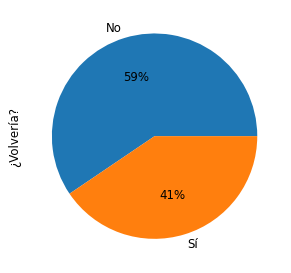

In [50]:
# Vemos en porcentaje si las personas volverían o no
plt.figure(dpi=85)
df.volveria.replace(to_replace=[True, False], value=["Sí", "No"]).value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel='¿Volvería?')

Podemos apreciar que la mayoría de los espectadores no volverían

<AxesSubplot:title={'center':'Cantidad de espectadores por tipo de sala'}, xlabel='Tipo de sala', ylabel='Cantidad de espectadores'>

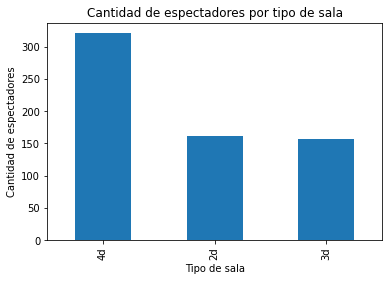

In [51]:
df['tipo_de_sala'].value_counts().sort_values(ascending=False) \
.plot(title = 'Cantidad de espectadores por tipo de sala', 
      xlabel = 'Tipo de sala', 
      ylabel = 'Cantidad de espectadores',
      kind='bar')

Graficamente vemos que la mayoria de los encuestados concurrieron a salas 4D

<AxesSubplot:title={'center':'Porcentaje de espectadores por sede'}>

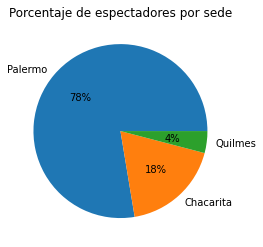

In [52]:
df['nombre_sede'].value_counts().sort_values(ascending=False) \
.plot(title = 'Porcentaje de espectadores por sede', 
      ylabel = '',
      kind='pie', 
      autopct='%1.0f%%')

La mayoría de las personas concurrieron a la sede de Palermo

<Figure size 900x600 with 0 Axes>

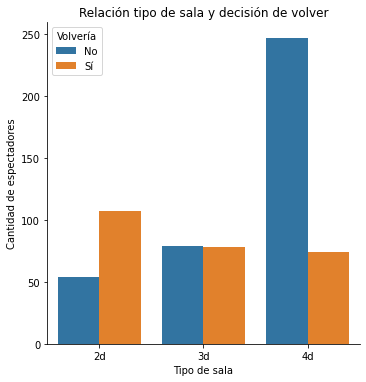

In [53]:
# Comparamos la sala a la que fueron y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "tipo_de_sala"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)

sns.catplot(data=df_aux, x='tipo_de_sala', y='count', hue='volveria', kind='bar', 
                legend=False, order=['2d', '3d', '4d'])

plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Tipo de sala")
plt.title('Relación tipo de sala y decisión de volver')
plt.show()

Podemos observar que en el caso de las salas:
* 2d es superior la cantidad de personas que decidirían volver respecto de las que no.
- 3d no se aprecia una diferencia significativa en la decisión de volver.
- 4d es considerable la cantidad de personas que no volverían comparada con las que sí.

Además observamos que si bien la cantidad de espectadores de las salas 2d es inferior a la de 4d, la cantidad de personas que decidiría volver es superior.

<Figure size 900x600 with 0 Axes>

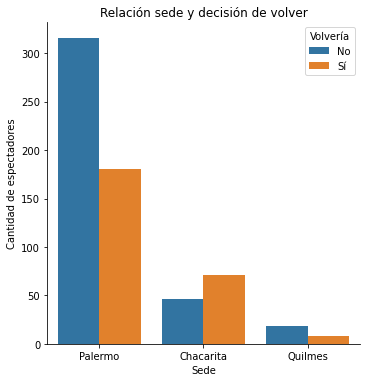

In [54]:
# Comparamos la sede a la que fueron y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "nombre_sede"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)

sns.catplot(data=df_aux, x='nombre_sede', y='count', hue='volveria', kind='bar', legend=False)

plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Sede")
plt.title('Relación sede y decisión de volver')
plt.show()

No podemos extraer un conclusión con este gráfico. 

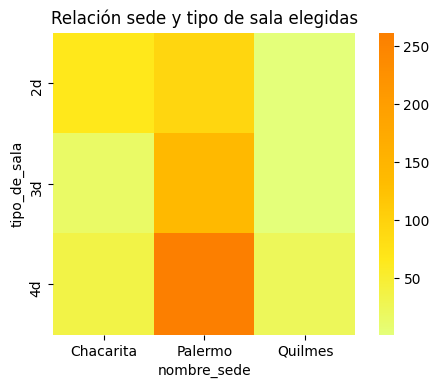

In [55]:
# Vemos cuales fueron las salas más elegidas según las sedes
plt.figure(dpi=100)

df_aux = df[["tipo_de_sala", "nombre_sede"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'

df_aux = df_aux.pivot("tipo_de_sala", "nombre_sede", "count")

plt.title('Relación sede y tipo de sala elegidas')
sns.heatmap(df_aux, square=True, cmap="Wistia", xticklabels=True)
plt.show()

Podemos ver que para todos los tipos de salas la sede más elegida fue Palermo y que la sala 4d de Palermo fue la más elegida de todas.

<AxesSubplot:ylabel='Género'>

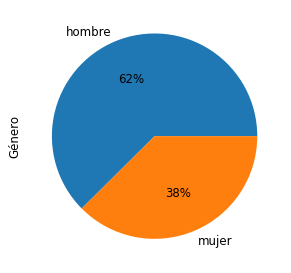

In [56]:
# Vemos en porcentaje el género de los espectadores
plt.figure(dpi=85)
df.genero.value_counts().plot(kind='pie', autopct='%1.0f%%', ylabel='Género')

Podemos ver que en su mayoría los espectadores son hombres.

<Figure size 900x600 with 0 Axes>

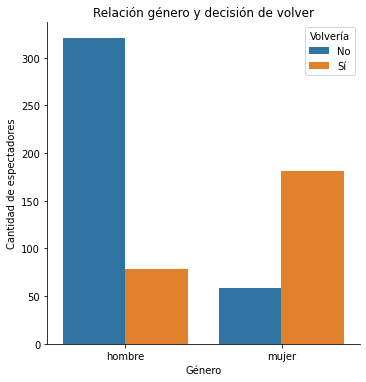

In [57]:
# Comparamos el género y la decisión de volver
plt.figure(dpi=150)
df_aux = df[["volveria", "genero"]].value_counts().reset_index()
df_aux.columns.values[2] = 'count'
df_aux.volveria.replace(to_replace=[True, False], value=["Sí", "No"], inplace=True)

sns.catplot(data=df_aux, x='genero', y='count', hue='volveria', kind='bar', legend=False)

plt.title('Relación género y decisión de volver')
plt.legend(title = "Volvería")
plt.ylabel("Cantidad de espectadores")
plt.xlabel("Género")
plt.show()


Podemos apreciar que incluso mientras que la cantidad de hombres que participaron es mayor que la cantidad de mujeres, es significativamente mayor la cantidad de mujeres que decidirían volver comparada con la cantidad de hombres que elegirían volver.

<AxesSubplot:title={'center':'Espectadores acompañados vs solos'}, ylabel='Cantidad de espectadores'>

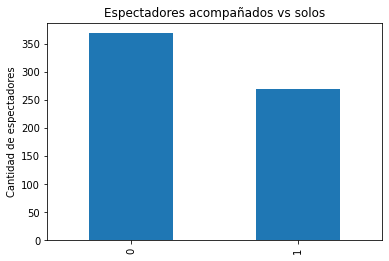

In [58]:
df['fue_acompanado'].value_counts().sort_values(ascending=False) \
.plot(title = 'Espectadores acompañados vs solos', 
      ylabel = 'Cantidad de espectadores',
      kind='bar')

La mayoría de las personas no van acompanadas al cine.

<AxesSubplot:title={'center':'Distribución de la cantidad de acompañantes'}, ylabel='Frequency'>

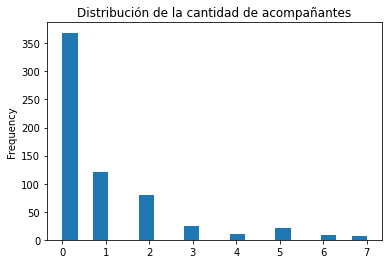

In [59]:
df['cantidad_acompanantes'] \
.plot(title = 'Distribución de la cantidad de acompañantes', 
      ylabel = '',
      kind='hist', 
      bins=20)

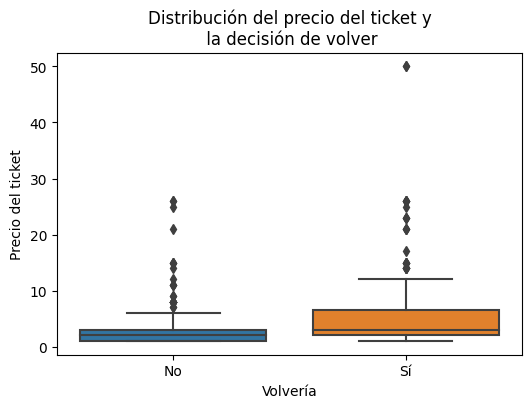

In [60]:
plt.figure(dpi=100)
plt.title("Distribución del precio del ticket y\n la decisión de volver")
sns.boxplot(
    data=df,
    y='precio_ticket',
    x='volveria'
)
plt.ylabel("Precio del ticket")
plt.xlabel("Volvería")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos ver que para ambos casos todos los valores superiores a, aproximadamente, 15 son outliers.

In [61]:
df_aux = df[["volveria", "genero", "tipo_de_sala", "nombre_sede"]].value_counts().reset_index()
df_aux.columns.values[-1] = 'cantidad_espectadores'
df_aux.volveria.replace(to_replace=[True, False], value=["sí", "no"], inplace=True)

<Figure size 432x288 with 0 Axes>

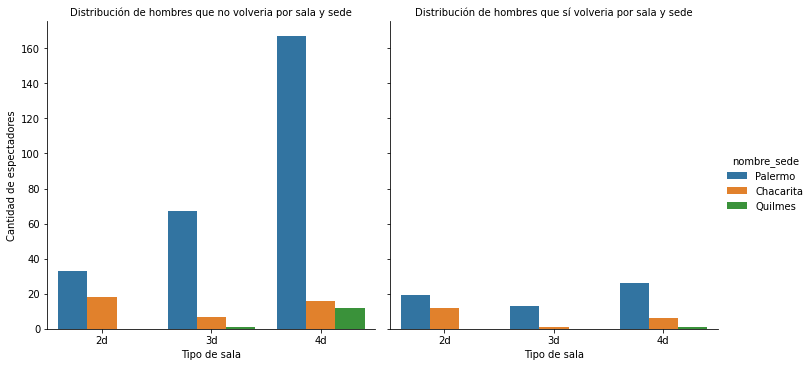

In [62]:
df_hombre = df_aux[df_aux["genero"] == "hombre"]

plt.figure()

g = sns.catplot(data=df_hombre, x='tipo_de_sala', y='cantidad_espectadores', hue='nombre_sede', kind='bar',
            order=['2d', '3d', '4d'], col='volveria')

(g.set_axis_labels("Tipo de sala", "Cantidad de espectadores")
  .set_titles("Distribución de hombres que {col_name} {col_var} por sala y sede"))  

plt.show()

<Figure size 432x288 with 0 Axes>

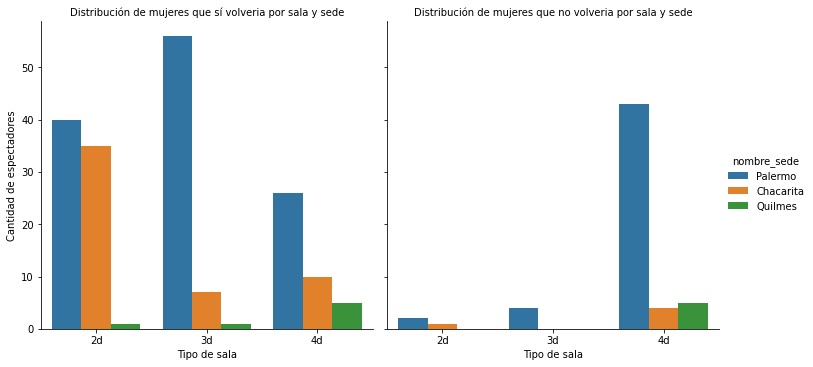

In [63]:
df_mujer = df_aux[df_aux["genero"] == "mujer"]

plt.figure()
g = sns.catplot(data=df_mujer, x='tipo_de_sala', y='cantidad_espectadores', hue='nombre_sede', kind='bar',
            order=['2d', '3d', '4d'], col ='volveria')

(g.set_axis_labels("Tipo de sala", "Cantidad de espectadores")
  .set_titles("Distribución de mujeres que {col_name} {col_var} por sala y sede")
)  

plt.show()

# Conclusiones

- Con el gráfico boxplot podemos ver que la mayoría de los valores representativos de la columna 'precio_ticket' es menor a 15 
  - df.drop(df[df['precio_ticket'] > 15].index, inplace=True)
  
  

- Con los últimos dos gráficos llegamos a las siguientes conclusiones
    - En el caso de los hombres para todas las sedes y salas la mayoría no volvería. 
    - En el caso de las mujeres 
        - Para las salas 2d y 3d se puede ver que en todas las sedes la mayoría volvería.
        - Para las salas 4d
            - En el caso de la sede de Chacarita la mayoría volvería
            - En el caso de la sede de Quilmes no se tiene suficiente información para establecer un comportamiento
            - En el caso de la sede de Palermo podemos notar que la mayoría no volvería
          

# Feature Engineering

In [64]:
def FeatureEngineering(df):
    
    df_clean = df.copy()
    
    df_clean.drop(columns=['nombre', 'id_ticket', 'id_usuario'], inplace = True)
    df_clean['cantidad_acompanantes'] = df_clean['amigos'] + df_clean['parientes']
    df_clean.drop(columns=['amigos', 'parientes'], axis=1, inplace = True)
    df_clean['fue_acompanado'] = df_clean['cantidad_acompanantes'].apply(lambda x: 1 if x > 0 else 0)
    df_clean['tipo_de_sala'].replace(to_replace = 'normal', value = '2d', inplace = True)
    df_clean['nombre_sede'].replace(to_replace = 'fiumark_quilmes', value ='Quilmes', inplace=True) 
    df_clean['nombre_sede'].replace(to_replace = 'fiumark_chacarita', value ='Chacarita', inplace=True) 
    df_clean['nombre_sede'].replace(to_replace = 'fiumark_palermo', value ='Palermo', inplace=True) 
    df_clean.drop(columns = 'fila', inplace = True)
    df_clean['edad'].fillna(df_clean['edad'].median(), inplace = True) 
            
    return df_clean

In [65]:
def Predict(df):
    pred = []
    values = df.values
    for val in values:
        if val[1] == 'hombre':
            pred.append(0)
        else:
            if (val[0] == '4d' and val[4] == 'Palermo'):
                pred.append(0)
            else:
                pred.append(1)
     
    return pred

In [66]:
def baseline(df):
    """    
    Input: dataframe
    Output: lista con las predicciones    
    """    
    # Aplicamos feature engineering a los datos de entrada
    entrada = FeatureEngineering(df)
    pred = Predict(entrada)
    
    return pred

In [67]:
# Generamos dataframe para probar
df_datos_test = GetDatosEncuesta()

df_volveria_test = GetEncuesta()
df_volveria_test = df_volveria_test.volveria


In [68]:
predicciones = baseline(df_datos_test)
accuracy_score(df_volveria_test, predicciones)

0.8202247191011236